<a href="https://colab.research.google.com/github/tmsandford/M33_Matching/blob/main/Auto_CMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install --upgrade pip
!pip install vaex
!pip install -Iv ipython==7.0.0
!pip install astroquery
!sudo pip install numpy --upgrade --ignore-installed

#Restart runtime!

In [ ]:
import sys
from astroquery.irsa import Irsa
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, fixed
import vaex


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/')
datadir = '/content/gdrive/My Drive/Colab Notebooks/'

Mounted at /content/gdrive


In [ ]:
def f_to_mag(flux):
    """Converts unWISE flux to Vega magnitude"""
    result = 22.5 - 2.5 * np.log10(flux)
    return result

In [ ]:
def cmd_setup(ra_min, ra_max, dec_min, dec_max, GridSize=100, height=8, width=20):
   
    """unWISE sources scatter plot"""
    Irsa.ROW_LIMIT = 100000
    data_table = Irsa.query_region("m33", catalog="unwise_2019", spatial="Polygon",
            polygon=[SkyCoord(ra=ra_min,dec=dec_min,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=ra_max,dec=dec_min,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=ra_max,dec=dec_max,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=ra_min,dec=dec_max,unit=(u.deg,u.deg),frame='icrs')])
    
    data_table['W1'] = f_to_mag(data_table['flux_1'])
    data_table['W2'] = f_to_mag(data_table['flux_2'])
    data_table['W2 - W1'] = data_table['W2'] - data_table['W1']
    
    fig, ax = plt.subplots(1,1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    
    ax.set_xlabel('W2 - W1', fontsize=20)
    ax.set_ylabel('W2', fontsize=20)
    ax.scatter(data_table['W2 - W1'],data_table['W2'], s=10,c='black')
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_title('unWISE', size=20)
    
    """HST sources 2d histogram"""
    hst_patch(ra_min, ra_max, dec_min, dec_max)
    
    ds = vaex.open(datadir+'M33_full_matched.hdf5')
    ds.select((ds.RA > ra_min) & (ds.RA < ra_max) & (ds.DEC > dec_min) & (ds.DEC < dec_max),name='SUB')
    import img_scale
    
    ra,dec = ds.RA.evaluate(selection='SUB'),ds.DEC.evaluate(selection='SUB')
    ra_m33, dec_m33 = 23.462*u.deg, 30.66*u.deg
    aspect_ratio = (ra.max()-ra.min())*np.cos(np.pi/180.*dec_m33) / (dec.max()-dec.min())


    ds['F275W_F336W'] = ds.F275W_VEGA - ds.F336W_VEGA

    F275W_F336W,F336W = ds.F275W_F336W.evaluate(selection='SUB'),ds.F336W_VEGA.evaluate(selection='SUB')

    n = 300
    hall,h275_336,h336 = np.histogram2d(F275W_F336W,F336W,
                              bins=[int(n*aspect_ratio),n],
                              range=[(-5.5,5.5), (18, 34)],
                              density=False)

    hall_scaled = img_scale.log(hall,scale_min=1,scale_max=100)

    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    ax = plt.subplot(111)
    ax.set_xlabel('F275W-F336W')
    ax.set_ylabel('F336W')

    colormap = 'viridis'
    cmap = getattr(mpl.cm, colormap)
    cmap.set_under('w')

    im = ax.imshow(hall_scaled.T,aspect='auto',
               interpolation='nearest',origin='lower',
               extent=[h275_336[0],h275_336[-1],h336[0],h336[-1]],
               cmap=cmap,vmin=0.01,vmax=1)

    ax.set_ylim(ax.get_ylim()[::-1])








In [ ]:
def cmds(ra_min_2, ra_max_2, dec_min_2, dec_max_2):
    interact(cmd_setup, ra_min=fixed(ra_min_2), ra_max=fixed(ra_max_2),
             dec_min=fixed(dec_min_2), dec_max=fixed(dec_max_2), 
             GridSize=(50,600,1), height=(1,30,0.5), width=(1,30,0.5)
            )

interactive(children=(IntSlider(value=100, description='GridSize', max=600, min=50), FloatSlider(value=8.0, de…

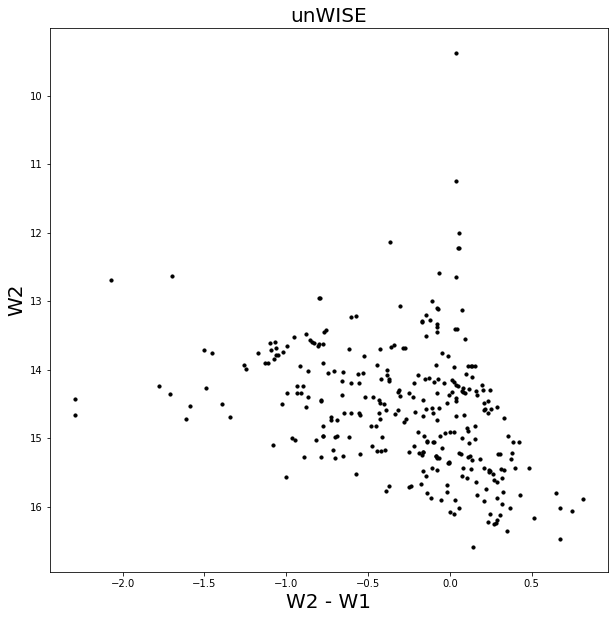

In [ ]:
cmds(23.43, 23.6, 30.71, 30.81)